Обучение модели на основе нейронной сети

In [23]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [24]:
targets = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']
data = pd.read_csv('./ready_train.csv')

features = list(set(list(data.columns)) - set(targets))

# Dataset и DataLoader

In [25]:
from imblearn.under_sampling import RandomUnderSampler

class SteelPlateDataset(Dataset):
    def __init__(self,X,y=None,balance=False):
        if balance:
            rus = RandomUnderSampler()
            self.X, self.y = rus.fit_resample(X, y)
        else:
            self.X = X
            self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        if self.y is not None:
            return self.X.iloc[index].values.astype(np.float32),self.y.iloc[index].astype(np.float32).reshape((-1))

        return self.X.iloc[index].values.astype(np.float32)

# Построение структуры нейросети

Для каждого класса будем строить свою модель обучения

Функции активации Relu, на последнем сигмоида, которая даст вероятность обнаружение данного класса дефекта.

In [26]:
class Net(nn.Module):
    def __init__(self,input_size):
        super(Net, self).__init__()

        self.mainSeq = nn.Sequential(
            nn.Linear(input_size,64),
            nn.ReLU(),

            nn.Linear(64,32),
            nn.ReLU(),

            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def forward(self, x):

       return self.mainSeq(x)

# Обучение

Глобальные параметры для обучения

In [27]:
# параметры
EPOCHS = 50
LEARNING_RATE = 1e-4
#


Функция для обучения модели предсказания для 1 класса

In [28]:
from tqdm import tqdm

def train_one_class(model,optimizer,criterion,train_loader,val_loader=None):

    train_tqdm = tqdm(range(EPOCHS))
    train_errors = []
    val_errors = []
    for epoch in train_tqdm:
        # train step
        model.train()
        train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader.dataset)
        train_errors.append(train_loss)

        train_tqdm.set_description(f"Loss = {train_loss:.5}")
        # val step
        val_loss = 0
        if val_loader is not None:
            model.eval()
            for X, y in val_loader:
                output = model(X)
                loss = criterion(output, y)
                val_loss += loss.item()
            val_loss = val_loss / len(val_loader.dataset)
            val_errors.append(val_loss)

            train_tqdm.set_description(f"Loss = {train_loss:.5}, Val = {val_loss:.5}")

    return [train_errors,val_errors]


Цикл для обучения по всем классам

Используем **BCELoss**, т.к. для каждого класса строим свой классификатор, соответственно бинарная кросс энтропия в качестве функции потерь

В качестве оптимизатора **Адам**

Количество **Эпох** и **Скорость обучения** выбраны экспериментальным путем

In [29]:
def train_one(y_class):

    #
    X_train, X_val, y_train, y_val = train_test_split(data[features], data[y_class], test_size=0.3, stratify=data[y_class])

    train_data = SteelPlateDataset(X_train,y_train,balance=True)
    val_data = SteelPlateDataset(X_val,y_val)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=32)
    #
    model = Net(X_train.shape[1])

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    err = train_one_class(model,optimizer,criterion,train_loader,val_loader)
    preds = None
    y_true = None
    model.eval()
    for x,y in val_loader:
        if preds is None:
            preds = model(x).detach().numpy()
            y_true = y
        else:
            preds = np.vstack([preds,model(x).detach().numpy()])
            y_true = np.vstack([y_true,y])

    rcs = roc_auc_score(y_val,preds).item()
    print(rcs)
    return model,err

In [30]:
def train_all():
    models = list()
    errors = list()
    for y_class in targets:
        model,err = train_one(y_class)

        models.append(model)
        errors.append(err)
    return models,errors

Параллельная версия функции обучения для ускорения

In [31]:
import multiprocessing as mp
import time

def process_train_one(y_class):
    model,err = train_one(y_class)
    return y_class, model, err

def train_all_parallel():
    start_time = time.time()

    # Создание пула процессов
    with mp.Pool(processes=7) as pool:
        # Список асинхронных задач
        async_results = []

        # Запускаем каждую задачу асинхронно
        for i in range(7):
            async_result = pool.apply_async(process_train_one, args=(targets[i],))
            async_results.append(async_result)

        # Собираем результаты
        results = [async_result.get() for async_result in async_results]

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Время выполнения: {total_time:.2f} секунд")
    models = list()
    errors = list()
    d = dict()

    for i in range(len(targets)):
        y_class,model,err = results[i]
        d[y_class] = model,err

    for i in range(len(targets)):
        models.append(d[targets[i]][0])
        errors.append(d[targets[i]][1])
    #
    return models,errors

In [32]:
models,errors = train_all_parallel()

Loss = 0.018402, Val = 0.019193:  44%|████▍     | 22/50 [03:56<04:57, 10.63s/it]

0.863028339132599


Loss = 0.013152:  86%|████████▌ | 43/50 [04:03<00:36,  5.25s/it]                

0.9776491634220772


Loss = 0.018322:  52%|█████▏    | 26/50 [04:33<03:26,  8.60s/it]                

0.9030861669811446


Loss = 0.020117, Val = 0.020443:  46%|████▌     | 23/50 [04:44<04:15,  9.45s/it]

0.8401854066985647


Loss = 0.018173, Val = 0.019099:  82%|████████▏ | 41/50 [05:36<00:35,  3.99s/it]

0.9753697169495456


Loss = 0.020007:  80%|████████  | 40/50 [06:02<00:35,  3.59s/it]                

0.747454313694347


Loss = 0.020028, Val = 0.020347: 100%|██████████| 50/50 [06:21<00:00,  7.64s/it]


0.682805842941624
Время выполнения: 383.24 секунд


Сохраним модели

In [33]:
def save_model(model,file_path):
    torch.save(model.state_dict(), file_path)

In [34]:
for i in range(len(targets)):
    save_model(models[i],f'./{targets[i]}.model')

# Метрики качества

Отрисовывает:
1. Кривые ошибки на обучении и валидации
2. AUC ROC

In [35]:
def plot_metrics(model,y_class,train_error,val_error):
    X,y = data[features],data[y_class]
    x_loader = torch.utils.data.DataLoader(SteelPlateDataset(X,y), batch_size=len(X))
    with torch.no_grad():
        for d,_ in x_loader:
            pred = model(d).detach().numpy()

    fig,ax = plt.subplots(1,2,figsize=(15,5))

    # lineplot
    sns.lineplot(train_error,c='b',ax=ax[0],label='Train')
    sns.lineplot(val_error,c='r',ax=ax[0],label='Val')
    ax[0].set(xlabel='Epochs',ylabel='Error', title='Model errors')
    # roc auc
    rcs = roc_auc_score(y,pred)

    display = RocCurveDisplay.from_predictions(y,pred,name=y_class,color="darkorange",plot_chance_level=True,despine=True,ax=ax[1])
    _ = display.ax_.set(xlabel="FPR", ylabel="TPR", title=f"ROC AUC for {y_class} with {rcs:.4} score")

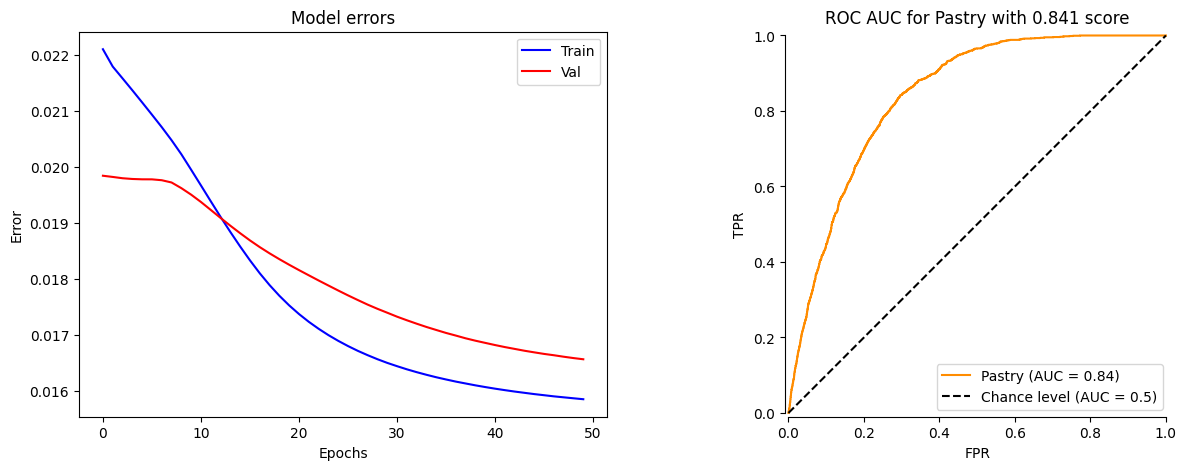

In [36]:
i = 0
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

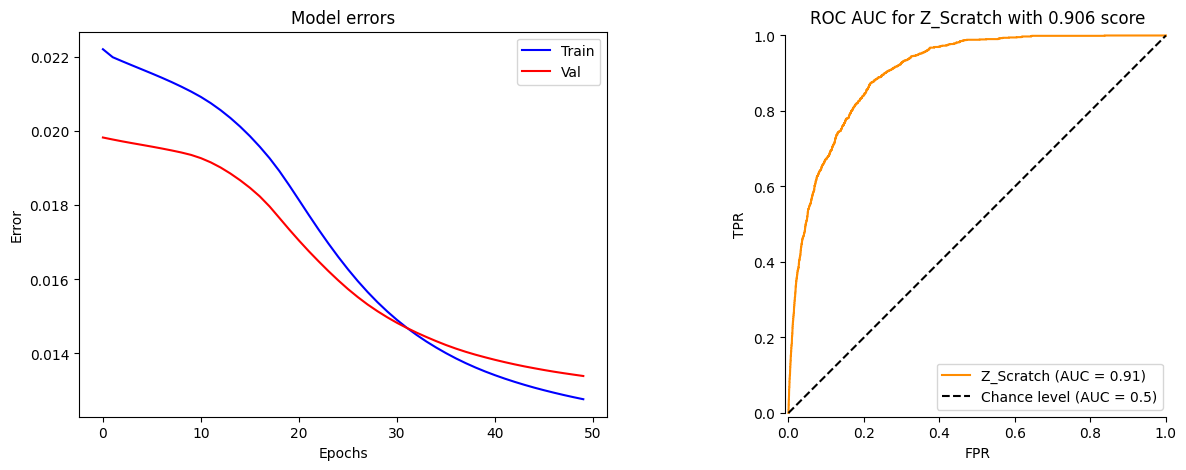

In [37]:
i = 1
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

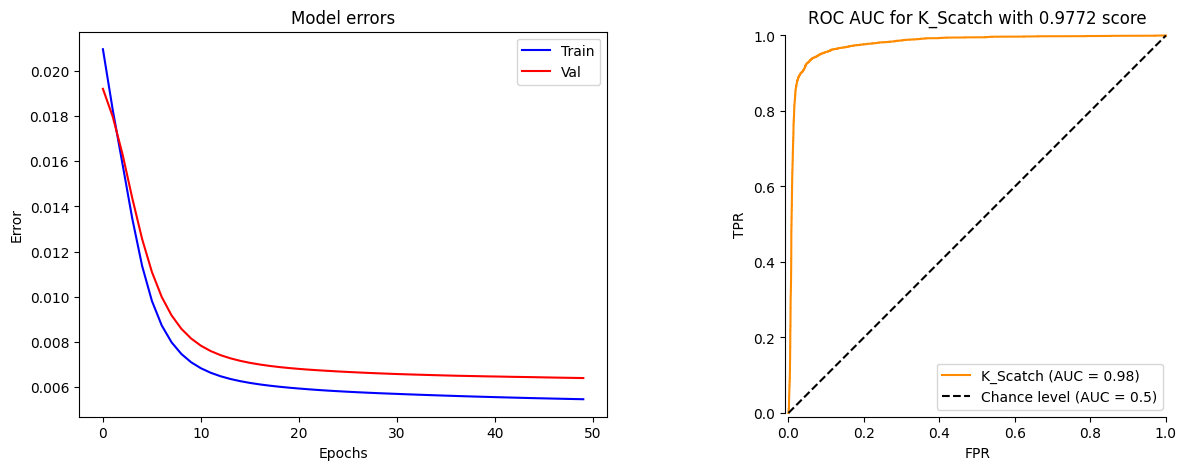

In [38]:
i = 2
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

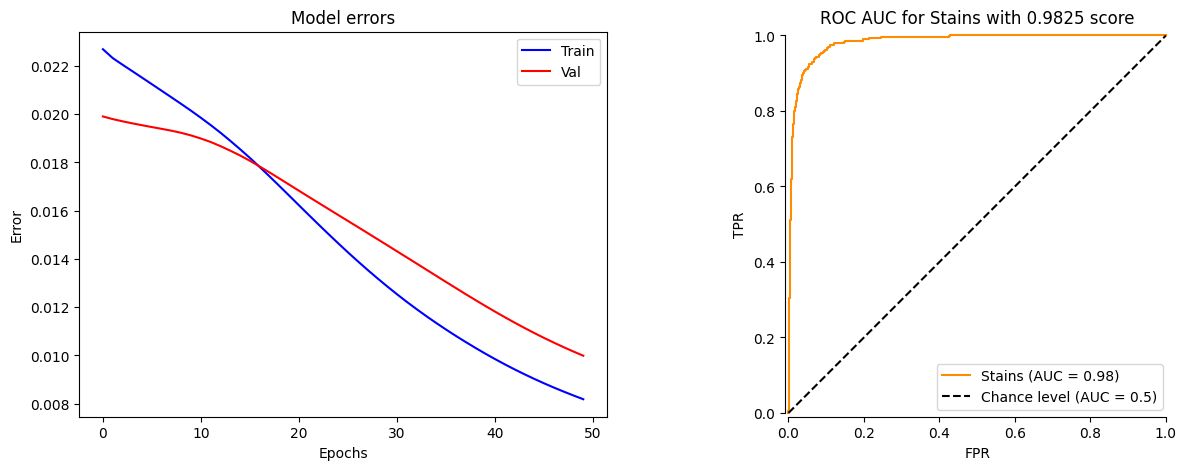

In [39]:
i = 3
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

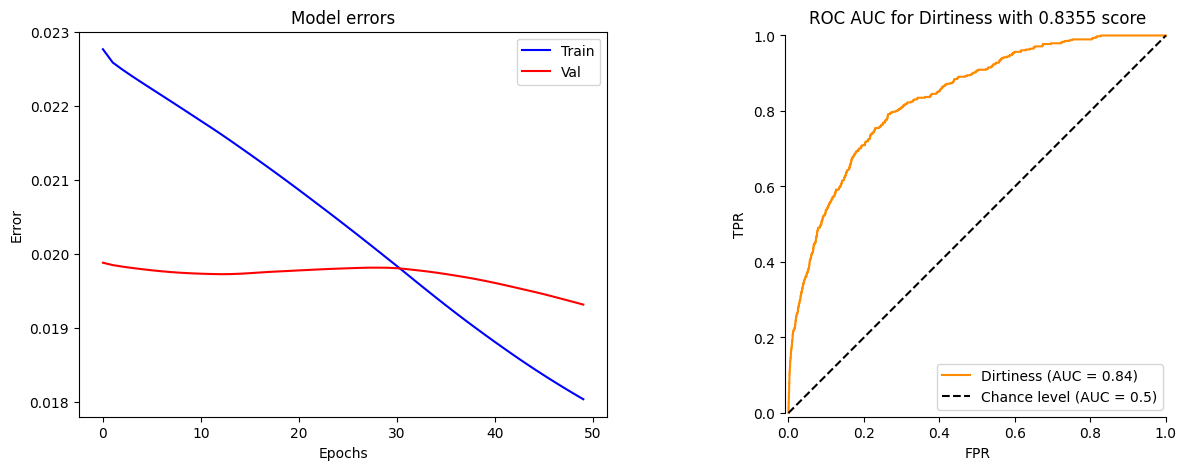

In [40]:
i = 4
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

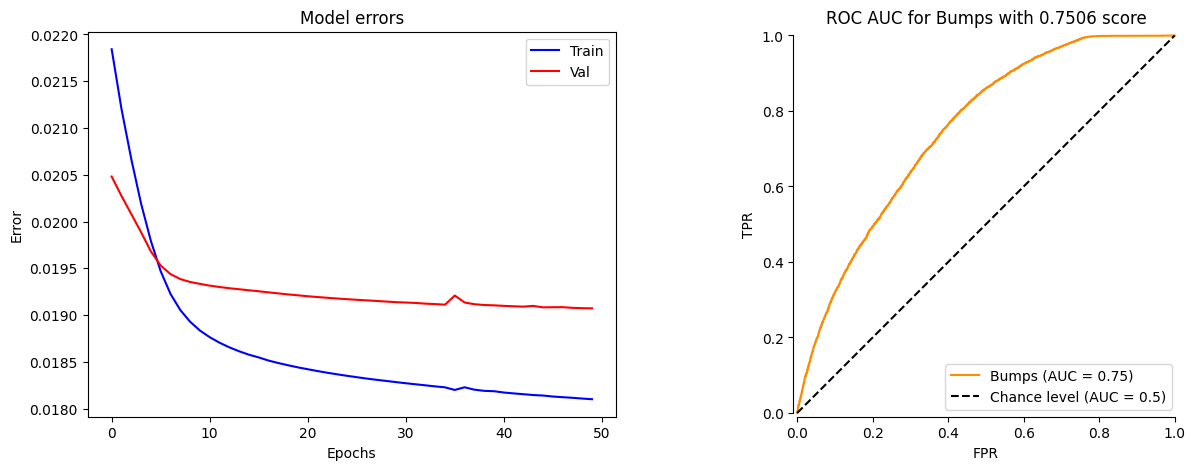

In [41]:
i = 5
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

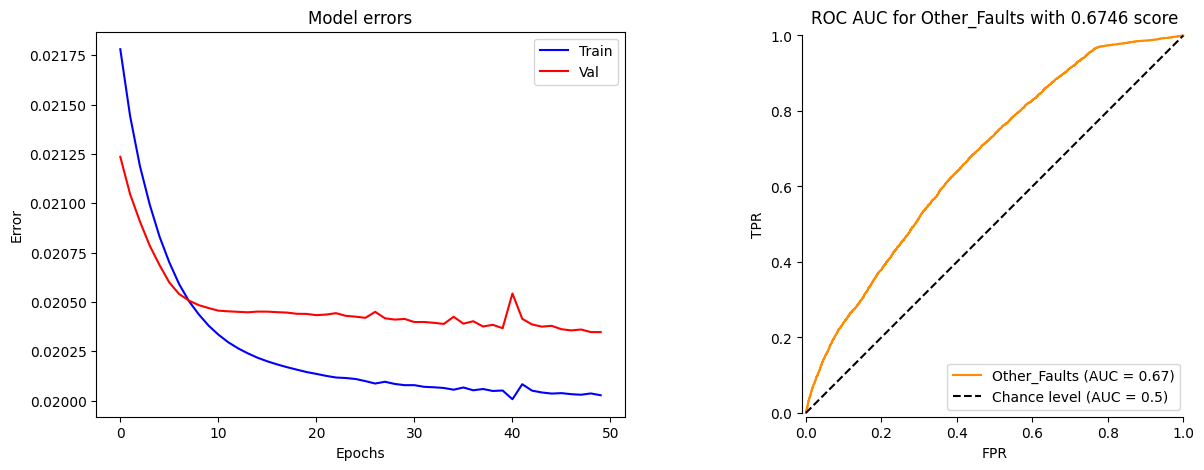

In [42]:
i = 6
plot_metrics(models[i],targets[i],errors[i][0],errors[i][1])

**Выводы**:

Первые 4 класса хорошо предсказываются построенной моделью.

С классами 'Bump','Other_Faults' и 'Dirtiness' стоит еще поработать, но пока оставлю так.

# Предсказания для тестовой выборки

In [43]:
test_df = pd.read_csv('./ready_test.csv')
test_data = SteelPlateDataset(test_df[features])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_df))

pred_df = test_df.copy()
pred_df['id'] = pd.read_csv('./test.csv')['id']
for i in range(len(targets)):
    with torch.no_grad():
        for d in test_loader:
            pred_df.loc[:,targets[i]] = models[i](d).numpy()

In [44]:
pred_df[['id']+targets].to_csv('./submission.csv',index=False)